In [2]:
import numpy as np
import torch
from scipy.io import loadmat
import matplotlib.pyplot as plt
import random

Dataset

In [15]:
data = loadmat('emnist-digits.mat')

In [16]:
X_train = data['dataset']['train'][0][0]['images'][0][0].astype('float64')[0:10000,:]
y_train = data['dataset']['train'][0][0]['labels'][0][0].ravel().astype('float64')[0:10000]
#y_train[y_train==26] = 0
X_test = data['dataset']['test'][0][0]['images'][0][0].astype('float64')[0:1000,:]
y_test = data['dataset']['test'][0][0]['labels'][0][0].ravel().astype('float64')[0:1000]
#y_test[y_test==26] = 0
print(f'forma X_train {X_train.shape} forma y_train {y_train.shape}')
print(f'forma X_test {X_test.shape} forma y_test {y_test.shape}')

forma X_train (10000, 784) forma y_train (10000,)
forma X_test (1000, 784) forma y_test (1000,)


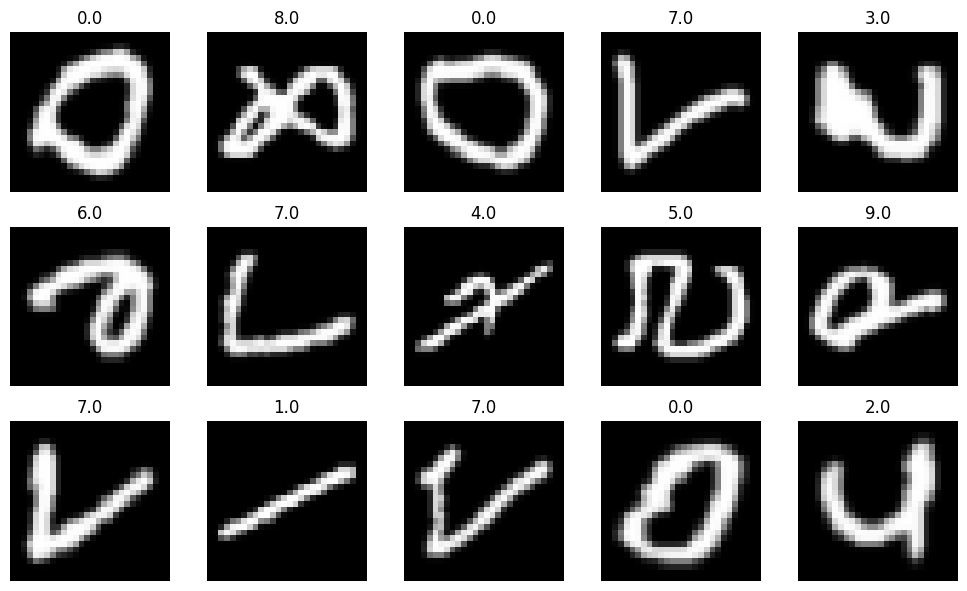

In [18]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_train)-1)
        img = X_train[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

Normalizacion

In [19]:
X_train /= 255.0
X_test /= 255.0

Funciones de activacion y pertida

In [20]:
# función de pérdida y derivada
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

Modelo

In [21]:
D_in, H1, H2, D_out = 784, 50, 20, 26

# Pesos capa oculta 1
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H1)),
          size = (D_in, H1)), requires_grad=True, device="cuda", dtype=torch.float)
b1 = torch.zeros(H1, requires_grad=True, device="cuda", dtype=torch.float)

# Pesos capa oculta 2
w2 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H2)),
          size = (H1, H2)), requires_grad=True, device="cuda", dtype=torch.float)
b2 = torch.zeros(H2, requires_grad=True, device="cuda", dtype=torch.float)

# Pesos capa de salida
w3 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_out+H2)),
          size = (H2, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
b3 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)

# convertimos datos a tensores y copiamos en gpu
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

Entrenamiento

In [22]:
epochs = 100
lr = 0.8
log_each = 10
l = []
for e in range(1, epochs+1):

    # forward
    z1 = X_t.mm(w1) + b1
    a1 = z1.clamp(min=0) # relu
    z2 = a1.mm(w2) + b2
    a2 = z2.clamp(min=0) # relu
    y_pred = a2.mm(w3) + b3

    # loss
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    with torch.no_grad():
        # update pesos
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad

        # ponemos a cero los gradientes para la siguiente iteración
        # (sino acumularíamos gradientes)
        w1.grad.zero_()
        w2.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()

    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

Epoch 10/100 Loss 2.81718
Epoch 20/100 Loss 2.58903
Epoch 30/100 Loss 2.33593
Epoch 40/100 Loss 2.11406
Epoch 50/100 Loss 1.91183
Epoch 60/100 Loss 1.70902
Epoch 70/100 Loss 1.54584
Epoch 80/100 Loss 1.41562
Epoch 90/100 Loss 1.30033
Epoch 100/100 Loss 1.20523
